# COVID-19 CT Image Classification 

## Overview

1. Data Preparation
2. Initial Model Development
3. Model Performance Using Data Augmentation
4. Transfer Learning

## 1. Data Preparation

* Import dependecies
* Extract file paths and split into training, validation, and test partitions
* Create Dataset Class to process and load images for PyTorch models 

### First we do wthout fold  cross

### 1.1 Import all dependencies

In [2]:
import os  
import glob
import sklearn
from sklearn.model_selection import train_test_split

import PIL 
import numpy as np
import matplotlib.pyplot as plt 

import cv2
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from glob import glob
# Helper libraries
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [3]:
if tf.test.is_gpu_available():
    print("GPU is available and TensorFlow is using it.")
else:
    print("No GPU available; TensorFlow is running on the CPU.")

GPU is available and TensorFlow is using it.


### Set Random Seed for reproducability

### 1.2 Generating Labels and Creating Sets for Modeling

Extract file links for both postive and negative images and split the dataset into train, validation, and test sets

In [4]:
import glob
path = '/kaggle/input/covidct/'


pos_files = glob.glob(os.path.join(path, "CT_COVID",'*.*'))
neg_files = glob.glob(os.path.join(path, 'CT_NonCOVID','*.*'))

images = pos_files + neg_files
labels = np.array([1]*len(pos_files)+[0]*len(neg_files))

images_train,images_test, y_train, y_test  = train_test_split(images, labels, shuffle=True, test_size=0.2, random_state=123)

From the plot below, observe that we have a balanced yet very small dataset at our disposal. Not ideal, but never the end of the road. Let's do our best to make the most out of what we have before we collect more data.

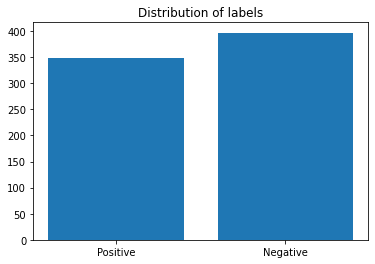

In [5]:
num_pos, num_neg = len(pos_files), len(neg_files)

plt.title('Distribution of labels')
plt.bar(['Positive', 'Negative'], [num_pos, num_neg])
plt.show()

Let's take a look at some of the images

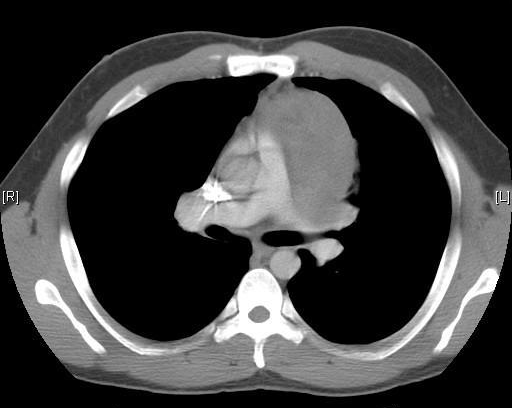

In [6]:
from IPython.display import Image
Image(images_train[14])

#### Get the sizes of the each dataset

In [7]:
print("Train sets images COVID: {}".format(len(images_train)))
print("Train sets images Non COVID: {}".format(len(y_train)))
print("Test sets images COVID: {}".format(len(images_test)))
print("Test sets images Non COVID: {}".format(len(y_test)))

total_train= len(images_train)
total_test= len(images_test)

Train sets images COVID: 596
Train sets images Non COVID: 596
Test sets images COVID: 150
Test sets images Non COVID: 150


### Simple CNN Model

Image type

In [27]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 128
IMG_WIDTH = 128

Directries

In [28]:
train_dir = os.path.join('/kaggle/working/train')
test_dir = os.path.join('/kaggle/working/test')

Create directries

In [29]:
# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [30]:
# Copy image files to the appropriate directories
for i, image_path in enumerate(images_train):
    if y_train[i] == 0:
        destination = os.path.join(train_dir, 'NonCOVID')
    else:
        destination = os.path.join(train_dir, 'COVID')
    os.makedirs(destination, exist_ok=True)
    shutil.copy(image_path, destination)

for i, image_path in enumerate(images_test):
    if y_test[i] == 0:
        destination = os.path.join(test_dir, 'NonCOVID')
    else:
        destination = os.path.join(test_dir, 'COVID')
    os.makedirs(destination, exist_ok=True)
    shutil.copy(image_path, destination)

### Train dataset generator

In [31]:
train_data_gen = ImageDataGenerator(
    rescale=1.0/255,  # Optional: Rescale pixel values
)

# Flow training images from the directory with batch size specified here
# train_generator = train_data_gen.flow_from_directory(
#     images_train,  # Provide your list of image data
#     y_train,
#     target_size=(IMG_HEIGHT, IMG_WIDTH),
#     batch_size=batch_size,  # Set the batch size here
#     class_mode='binary'
# )
# images_train = np.array(images_train)  # Convert to NumPy array if not already
# y_train = np.array(y_train)  # Convert labels to NumPy array if not already

# train_generator = train_data_gen.flow(
#     images_train,  # Provide your list of image data
#     y_train,  # Provide your list of labels
#     batch_size=batch_size,  # Set the batch size here
#     shuffle=True
# )

train_generator = train_data_gen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)



Found 596 images belonging to 2 classes.


### Test datset Generator

In [32]:
test_data_gen = ImageDataGenerator(rescale=1.0/255)  # Optional: Rescale pixel values

# Create the test data generator
test_generator = test_data_gen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Set shuffle to False for the test set
)

Found 150 images belonging to 2 classes.


In [39]:
model = Sequential([
    Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(2,2),
    #Dropout(0.25),
    Conv2D(32, (3,3), padding='same', activation='relu'),
    MaxPooling2D(2,2),
    #Dropout(0.25),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPooling2D(2,2),
    #Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    #Dropout(0.25),
    Dense(128, activation='relu'),
    #Dropout(0.25),
    Dense(1,activation='sigmoid' )
])

In [40]:
# Define a custom F1 score metric
# def f1_score(y_true, y_pred):
#     true_positives = tf.reduce_sum(tf.cast(y_true * tf.round(y_pred), tf.float32))
#     predicted_positives = tf.reduce_sum(tf.round(y_pred))
#     actual_positives = tf.reduce_sum(y_true)
    
#     precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
#     recall = true_positives / (actual_positives + tf.keras.backend.epsilon())
    
#     f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    
#     return f1

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

In [41]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 16384)            

### Train the datset

In [42]:

history=model.fit(
    train_generator,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=test_generator,  # Use the test_generator for validation data
    validation_steps=total_test // batch_size
)

Epoch 1/15


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


4/4 [==============================] - 4s 883ms/step - loss: 1.0679 - accuracy: 0.5021 - val_loss: 0.6641 - val_accuracy: 0.7578
Epoch 2/15
4/4 [==============================] - 3s 669ms/step - loss: 0.7100 - accuracy: 0.5598 - val_loss: 0.7495 - val_accuracy: 0.4453
Epoch 3/15
4/4 [==============================] - 2s 678ms/step - loss: 0.6798 - accuracy: 0.5577 - val_loss: 0.6641 - val_accuracy: 0.6094
Epoch 4/15
4/4 [==============================] - 3s 678ms/step - loss: 0.6496 - accuracy: 0.6132 - val_loss: 0.6058 - val_accuracy: 0.6953
Epoch 5/15
4/4 [==============================] - 3s 733ms/step - loss: 0.6133 - accuracy: 0.6603 - val_loss: 0.5564 - val_accuracy: 0.7188
Epoch 6/15
4/4 [==============================] - 3s 817ms/step - loss: 0.5670 - accuracy: 0.7179 - val_loss: 0.6093 - val_accuracy: 0.7031
Epoch 7/15
4/4 [==============================] - 3s 666ms/step - loss: 0.5125 - accuracy: 0.7543 - val_loss: 0.5524 - val_accuracy: 0.7266
Epoch 8/15
4/4 [===============

### Show training and test accuracy

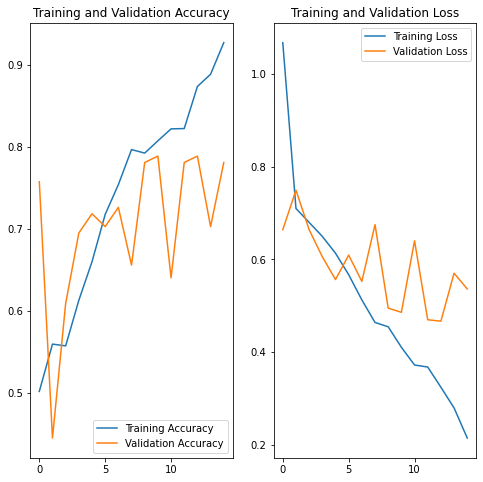

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Confution matrix

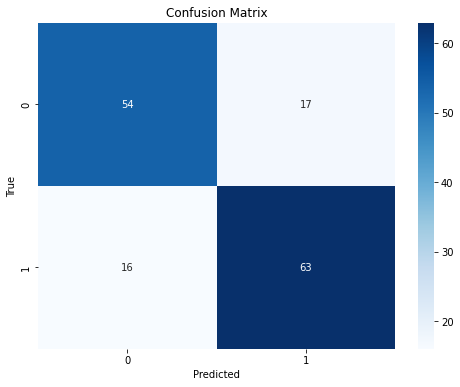

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Assuming you have predictions and true labels
predictions = model.predict(test_generator)  # Replace with your test data
predicted_classes = [1 if p > 0.5 else 0 for p in predictions]  # Assuming binary classification
true_classes = test_generator.classes  # True labels from the test data

# Calculate the confusion matrix
confusion = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## precision, recall, and F1 score

In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have predictions and true labels
predictions = model.predict(test_generator)  # Replace with your test data
predicted_classes = [1 if p > 0.5 else 0 for p in predictions]  # Assuming binary classification
true_classes = test_generator.classes  # True labels from the test data

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)

# Calculate precision, recall, and F1 score
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.78
Precision: 0.79
Recall: 0.80
F1 Score: 0.79


## Do the whole process using KFold

In [46]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os  
import glob
import sklearn
from sklearn.model_selection import train_test_split

import PIL 
import numpy as np
import matplotlib.pyplot as plt 

import cv2
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from glob import glob
# Helper libraries
import matplotlib.pyplot as plt
import math
%matplotlib inline



from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers



In [47]:
def data_genner(diry,batch_size,IMG_HEIGHT, IMG_WIDTH):
    data_gen = ImageDataGenerator(
        rescale=1.0/255,  # Optional: Rescale pixel values
    )

    generator = data_gen.flow_from_directory(
        diry,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )
    return generator


def get_model(train_generator,test_generator,batch_size,epochs):
    model = Sequential([
        Conv2D(20, (3,3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
        MaxPooling2D(2,2),
#         Dropout(0.25),
        Conv2D(30, (3,3), padding='same', activation='relu'),
        MaxPooling2D(2,2),
#         Dropout(0.25),
        Conv2D(20, (3,3), padding='same', activation='relu'),
        MaxPooling2D(2,2),
        Dropout(0.25),
        Flatten(),
        Dense(56, activation='relu'),
        Dropout(0.25),
        Dense(16, activation='relu'),
        #Dropout(0.25),
        Dense(1,activation='sigmoid' )
    ])
    
    model.compile(optimizer='adam',#Adam(learning_rate=0.001)
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    history=model.fit(
        train_generator,
        steps_per_epoch=total_train // batch_size,
        epochs=epochs,
        validation_data=test_generator,  # Use the test_generator for validation data
        validation_steps=total_test // batch_size
    )
    
    return model


def get_pretrin_transfer_model(train_generator,test_generator,batch_size,epochs):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    # Freeze the convolutional layers of VGG-19
    for layer in base_model.layers:
        layer.trainable = False
        
        
    model = Sequential([
        base_model,
        Flatten(),
        Dense(56, activation='relu'),
        Dropout(0.25),
        Dense(16, activation='relu'),
        #Dropout(0.25),
        Dense(1,activation='sigmoid' )
    ])
    
    model.compile(optimizer='adam',#Adam(learning_rate=0.001)
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    history=model.fit(
        train_generator,
        steps_per_epoch=total_train // batch_size,
        epochs=epochs,
        validation_data=test_generator,  # Use the test_generator for validation data
        validation_steps=total_test // batch_size
    )
    
    return model

def save_paths(images_train,images_test, y_train, y_test):
    # Copy image files to the appropriate directories
    for i, image_path in enumerate(images_train):
        if y_train[i] == 0:
            destination = os.path.join(train_dir, 'NonCOVID')
        else:
            destination = os.path.join(train_dir, 'COVID')
        os.makedirs(destination, exist_ok=True)
        shutil.copy(image_path, destination)

    for i, image_path in enumerate(images_test):
        if y_test[i] == 0:
            destination = os.path.join(test_dir, 'NonCOVID')
        else:
            destination = os.path.join(test_dir, 'COVID')
        os.makedirs(destination, exist_ok=True)
        shutil.copy(image_path, destination)


def get_details(model,test_generator):
    # Assuming you have predictions and true labels
    predictions = model.predict(test_generator)  # Replace with your test data
    predicted_classes = [1 if p > 0.5 else 0 for p in predictions]  # Assuming binary classification
    true_classes = test_generator.classes  # True labels from the test data

    # Calculate accuracy
    accuracy = accuracy_score(true_classes, predicted_classes)

    # Calculate precision, recall, and F1 score
    precision = precision_score(true_classes, predicted_classes)
    recall = recall_score(true_classes, predicted_classes)
    f1 = f1_score(true_classes, predicted_classes)
    print(accuracy,precision,recall,f1)
    
    return accuracy,precision,recall,f1

    # Print the metrics
#     print(f"Accuracy: {accuracy:.2f}")
#     print(f"Precision: {precision:.2f}")
#     print(f"Recall: {recall:.2f}")
#     print(f"F1 Score: {f1:.2f}")
    


In [48]:
# Define the number of folds
n_splits = 5
# Initialize the cross-validator
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)


batch_size = 128
epochs = 15
IMG_HEIGHT = 128
IMG_WIDTH = 128

import glob
path = '/kaggle/input/covidct/'


pos_files = glob.glob(os.path.join(path, "CT_COVID",'*.*'))
neg_files = glob.glob(os.path.join(path, 'CT_NonCOVID','*.*'))

images = pos_files + neg_files
labels = np.array([1]*len(pos_files)+[0]*len(neg_files))

In [49]:

train_dir = os.path.join('/kaggle/working/train')
test_dir = os.path.join('/kaggle/working/test')

# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# for train_index, val_index in kf.split(images,labels):
#     # Split the data into training and validation sets
#     X_train, X_val = images[train_index], images[val_index]
#     y_train, y_val = labels[train_index], labels[val_index]
# #     print(y_train)
#     X_train = [item for sublist in X_train for item in sublist]
# #     train_generator=data_genner(X_train,batch_size,IMG_HEIGHT, IMG_WIDTH)
# #     test_generator=data_genner( X_val,batch_size,IMG_HEIGHT, IMG_WIDTH)
# #     get_model(train_generator,test_generator,batch_size,epochs)
    
random_numbers =  [random.randint(1, 1000) for _ in range(5)]
accuracy_list=[]
precision_list=[]
recall_list=[]
f1_list=[]

for random_num in random_numbers:
    # Split the data into training and validation sets
    images_train,images_test, y_train, y_test  = train_test_split(images, labels, shuffle=True, test_size=0.2, random_state=random_num)
#     print(y_train)
    save_paths(images_train,images_test, y_train, y_test)
    total_train= len(images_train)
    total_test= len(images_test)
    train_generator=data_genner(train_dir,batch_size,IMG_HEIGHT, IMG_WIDTH)
    test_generator=data_genner(test_dir,batch_size,IMG_HEIGHT, IMG_WIDTH)
    #model=get_model(train_generator,test_generator,batch_size,epochs) 
    model=get_pretrin_transfer_model(train_generator,test_generator,batch_size,epochs)
    accuracy,precision,recall,f1 = get_details(model,test_generator)
    accuracy_list+=[accuracy]
    precision_list+=[precision]
    recall_list+=[recall]
    f1_list+=[f1]

    

    
    
    
    

Found 720 images belonging to 2 classes.
Found 274 images belonging to 2 classes.
80150528/80134624 [==============================] - 4s 0us/step
Epoch 1/15
4/4 [==============================] - 10s 2s/step - loss: 0.7856 - accuracy: 0.4935 - val_loss: 0.6500 - val_accuracy: 0.5781
Epoch 2/15
4/4 [==============================] - 3s 894ms/step - loss: 0.6394 - accuracy: 0.6228 - val_loss: 0.6400 - val_accuracy: 0.5781
Epoch 3/15
4/4 [==============================] - 3s 858ms/step - loss: 0.6175 - accuracy: 0.6562 - val_loss: 0.5603 - val_accuracy: 0.6875
Epoch 4/15
4/4 [==============================] - 3s 786ms/step - loss: 0.5595 - accuracy: 0.7155 - val_loss: 0.5109 - val_accuracy: 0.7422
Epoch 5/15
4/4 [==============================] - 3s 845ms/step - loss: 0.5164 - accuracy: 0.7500 - val_loss: 0.4717 - val_accuracy: 0.8125
Epoch 6/15
4/4 [==============================] - 3s 813ms/step - loss: 0.4626 - accuracy: 0.7802 - val_loss: 0.4232 - val_accuracy: 0.8516
Epoch 7/15
4/4 

In [50]:
print("average of accuracy = ",sum(accuracy_list) / len(accuracy_list))
print("average of precision = ",sum(precision_list) / len(precision_list))
print("average of recall = ",sum(recall_list) / len(recall_list))
print("average of f1 = ",sum(f1_list) / len(f1_list))


average of accuracy =  0.5136161660656767
average of precision =  0.5497051095457144
average of recall =  0.5452144198674349
average of f1 =  0.5464589846223733


In [51]:
print(accuracy_list)

[0.5328467153284672, 0.5093333333333333, 0.49333333333333335, 0.5098814229249012, 0.5226860254083484]


### Conclution